In [3]:
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'1.13.1'

In [29]:
data = pd.read_csv('train.csv')
data.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [30]:
data = data.dropna()
x = data.drop('label', axis = 1)
y = data['label']
print(x.shape, y.shape)

(18285, 4) (18285,)


In [55]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.python.keras.layers import LSTM, Dense, Dropout

In [31]:
#Defining vocabulary size
vocab_size = 5000
#Resetting index because we've dropped NaN values before
msg = x.copy()
msg.reset_index(inplace = True)

In [16]:
import re
import nltk
from nltk.corpus import stopwords

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/satyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
#Data Preprocessing
from nltk.stem.porter import PorterStemmer
porter_stem = PorterStemmer()
corpus = []

In [35]:
for i in range(0, len(msg)):
    rvw = re.sub('[^a-zA-z]', ' ', msg['title'][i])
    rvw = rvw.lower()
    rvw = rvw.split()
    rvw = [porter_stem.stem(word) for word in rvw if not word in stopwords.words('english')]
    rvw = ' '.join(rvw)
    corpus.append(rvw)

In [37]:
#One Hot Encoding
onehot = [one_hot(words, vocab_size) for words in corpus]

In [40]:
#Padding the onehot length because embedding layer requires sentences of equal length
sentence_length = 20
embed_doc = pad_sequences(onehot, padding = 'pre', maxlen = sentence_length)
len(embed_doc)

18285

In [56]:
#Creating the model
embedding_vec_features = 25
model = Sequential()
model.add(Embedding(vocab_size, embedding_vec_features, input_length = sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
#Dense layer with sigmoid activation because this is a classification problem and we need 1 output
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 25)            125000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 25)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 175,501
Trainable params: 175,501
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
import numpy as np
x_final = np.array(embed_doc)
y_final = np.array(y)
print(x_final.shape, y_final.shape)

(18285, 20) (18285,)


In [58]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_final, y_final, test_size = 0.3, random_state = 42)

In [65]:
#Training the Model
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, batch_size = 64)

Train on 12799 samples, validate on 5486 samples
Epoch 1/10
12799/12799 [==============================] - 8s 612us/sample - loss: 0.0485 - acc: 0.9827 - val_loss: 0.3364 - val_acc: 0.9171
Epoch 2/10
12799/12799 [==============================] - 8s 616us/sample - loss: 0.0397 - acc: 0.9864 - val_loss: 0.3712 - val_acc: 0.9134
Epoch 3/10
12799/12799 [==============================] - 8s 609us/sample - loss: 0.0392 - acc: 0.9848 - val_loss: 0.3337 - val_acc: 0.9112
Epoch 4/10
12799/12799 [==============================] - 8s 616us/sample - loss: 0.0336 - acc: 0.9884 - val_loss: 0.3293 - val_acc: 0.9058
Epoch 5/10
12799/12799 [==============================] - 8s 618us/sample - loss: 0.0367 - acc: 0.9876 - val_loss: 0.3554 - val_acc: 0.9085
Epoch 6/10
12799/12799 [==============================] - 8s 627us/sample - loss: 0.0296 - acc: 0.9891 - val_loss: 0.4069 - val_acc: 0.9098
Epoch 7/10
12799/12799 [==============================] - 8s 626us/sample - loss: 0.0283 - acc: 0.9901 - val_lo

In [74]:
y_pred = model.predict_classes(x_val)

In [75]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[2873,  234],
       [ 302, 2077]])

In [76]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9022967553773241

In [77]:
import matplotlib.pyplot as plt

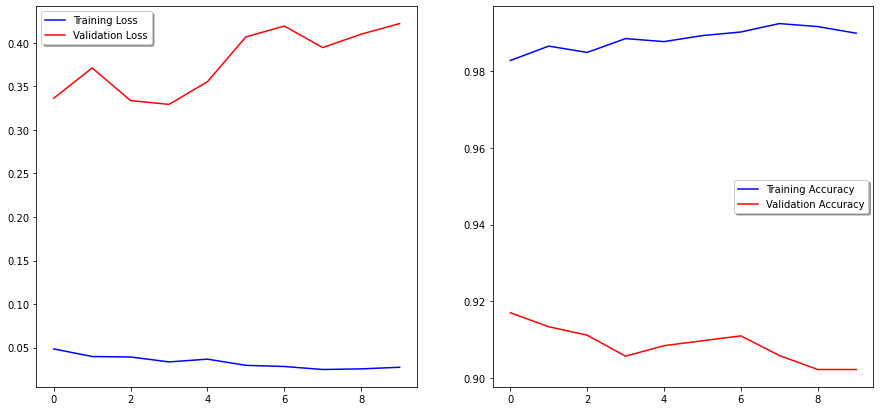

In [78]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['acc'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_acc'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

In [106]:
def test(X):
    X = X.fillna(0)
    messages = X.copy()
    messages.reset_index(inplace=True)
    testcorpus=[]
    
    for i in range(len(messages)):
        reviews=re.sub('[^a-zA-Z]',' ',str(messages['title'][i]))
        reviews=reviews.lower()
        reviews=reviews.split()
        reviews=[porter_stem.stem(word) for word in reviews if word not in stopwords.words('english')]
        reviews=' '.join(reviews)
        testcorpus.append(reviews)
    one_hot_rep=[one_hot(word,vocab_size)for word in testcorpus]
    embedded_docs = pad_sequences(one_hot_rep, padding = 'pre', maxlen = sentence_length)
    X_final = np.array(embedded_docs)
    
    return X_final

In [107]:
test_data = pd.read_csv('test.csv')
test_final = test(test_data)

In [108]:
test_pred = model.predict(test_final)
test_pred.shape

(5200, 1)

In [109]:
submission_data = pd.read_csv('submit.csv')
submission_data['label']=np.round(test_pred).astype('int')
submission_data.to_csv('Submission.csv',index=False)